In [9]:
import numpy as np

a = np.array([1, 2, 3])
b = np.array([3, 10, 7])
c = np.array([a, b])

np.average([a, b], weights=[0.6, 0.4], axis=0)

array([1.8, 5.2, 4.6])

# Graph Neural Networks (GNN)

GNN is used for processing data that are represented in graph form - set of nodes + set of edges + list of connections between nodes and edges. Additional data can be stored in nodes and/or edges.

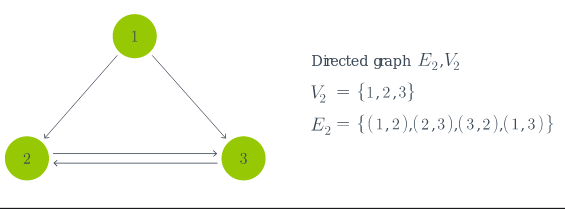

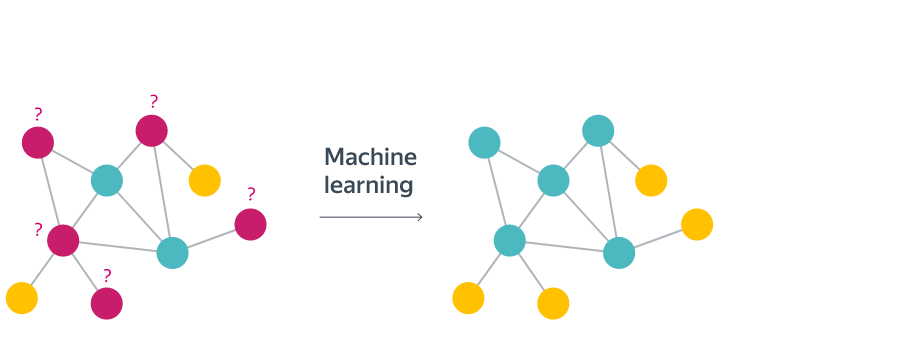

### Graph tasks:

- classification
- regression
- restoration of missed nodes / edges
- generation of graph with certain properties
- graph clusterization
- etc.

Graph tasks can be **graph-level** (e.g. classification of molecules), **node-level** (prediction of user's interests by his/her friends) and **edge-level** (predict if one person in social graph is freind/colleage to another person).

### Graph representation in GNN

Graph is usually represented as: 
- adjacency matrix *A* (N x N, where N - number of nodes) that shows that node i is connected with node j
- node features/embeddings matrix *F* (N x k, where k - number of features)
- edge matrix *E* which descirbes the properties of the edges of graph

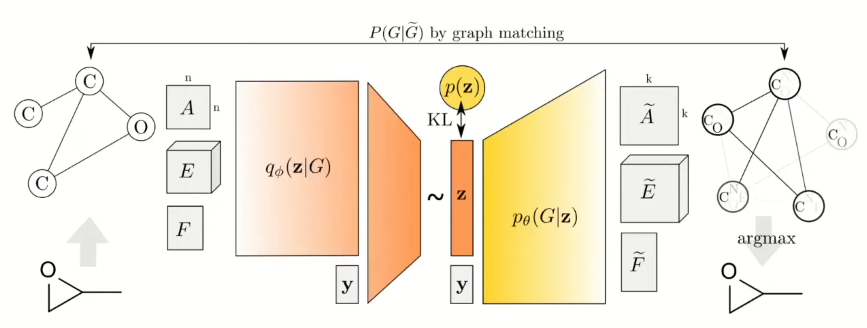

Not every graph demands all 3 matrices, usually only matrices A and F or matrices A and E is used.

In arbitrary graphs, the order of nodes may not be important (unlike in image and text graphs). Therefore, when processing graphs, the **Equivariance** property is often important: if, for example, a layer of a network transforms node labels, there should be a corresponding transform of the output labels, because labels is the only way to distinguish the nodes in such a graph. Look at the picture below: two nodes are indistinguishable in terms of the graph structure, so if their labels are changed and passed through a graph network, the output labels should also change. That's why it's impossible to send adjacency matrix to convolution layer - the nodes are forcibly ordered in this layer and the result is not equivariant.

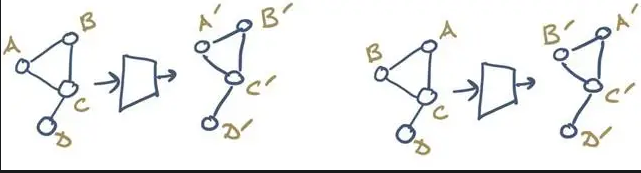

### GNN architecture

- use graph convolutions in the input layers (collect inforamtion from neighbour nodes and update iformation about current node)

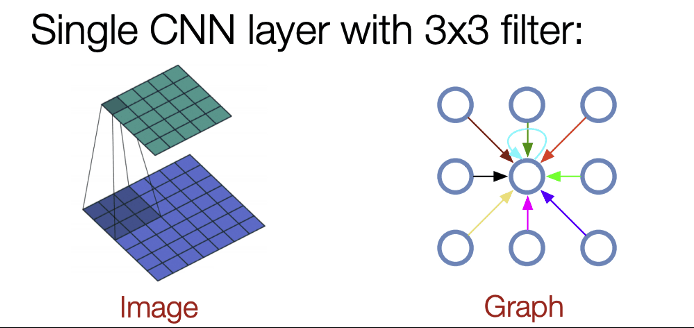

- pooling is almost never used, i.e. in most of GNN architectures input graph structure is the same as output graph structure
- use MLP layers in the output layer
- use readout operation (max, mean, self-attention, etc.; any operations that are invariant to node/edge permutations in graph) to translate information from graph convolutions to MLP layers
- Dropout (drop nodes and/or edges with some probability)
- LayerNorm (BatchNorm for every graph in GNN layers) 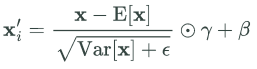
- GraphNorm (more flexible normalization method) 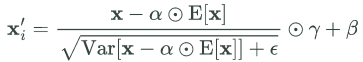

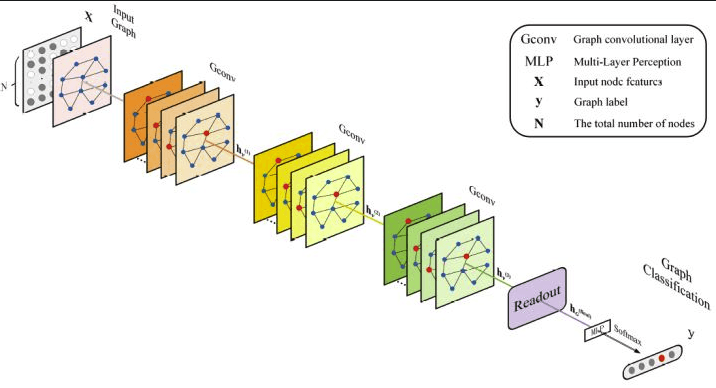

### Graph node representation

Can be **spatial** (message-passing paradigm) and **spectral** (use graph Laplacian and its eigenvectors).

#### Spatial paradigm

Main idea: every node has its inner state, during every iteration this inner state is recalculated based on inner states of node neighbours. Each neighbour influences on node's state and vice versa. State are updated using **Message Passing** approach.

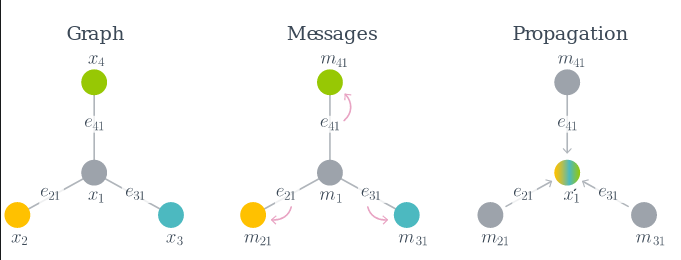

The iteration of the Message Passing approach for a single node can be described by the following abstract algorithm. For each node, collect all triples (x<sub>u</sub>, x<sub>w</sub>, e<sub>uw</sub>) consisting of the hidden representations of the current node and its neighbor, as well as the type of the edge connecting the current node and its neighbor. Then apply a trainable transformation M (referred to as "message") to all these triples and computes the message - the information that goes from the neighbor x<sub>w</sub> to the node x<sub>u</sub>. The computed messages are aggregated into one message m<sub>u</sub>. Messages can be aggregated by any associative operation, for example, element-wise minimum, maximum, or mean. Then, the aggregated message and the current internal state of the vertex are sent to the input of a trainable operation U (referred to as "update"), which updates the internal state of the vertex.

Example of aggregation operation that is used in original GNNs

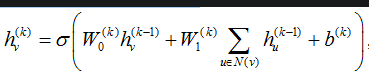, i.e. it's simple sum, every element of which is passed through linear layer and then this sum is passed through activation function.

##### Spacial paradigm implementations

- PageRank - the most famous graph algorithm that is used in Google for page ranking
- GraphSage - for each vertex, a set of hidden representations of neighboring vertices h<sub>w</sub><sup>t</sup> is computed. Then, the gathered information is aggregated using a commutative operation AGGR into a fixed-size vector. As an aggregation operation, the authors propose using average or maximum values of the hidden representations. Next, the aggregated vector is concatenated with the hidden node representation h<sub>u</sub><sup>t</sup>, multiplied by a trainable matrix W, and the element-wise sigmoid function is applied to the multiplication result. The trainable parameters of this layer only consist of a single matrix

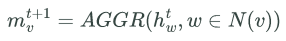

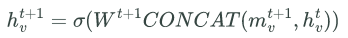

- Graph ATtention (GAT) - evolution of the GraphSAGE concept. As an aggregation mechanism, this architecture suggests using an attention mechanism, where the K, Q and V matrices are the same and denoted as W in the formula below. Similar to GraphSAGE, the aggregated message passes through a sigmoid, but it is not multiplied by a trainable matrix beforehand. *act* is some activation function. As for attention mechanism, during the update of node *u* representation, self-attention *a* "looks" at the rest neighbour nodes * and generates weights α<sub>u</sub><sup>\*</sup> that show importance of information from every node.

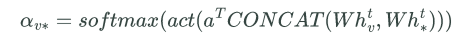

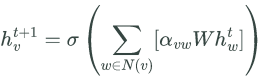

GraphSage and GAT by default use only information from nodes, but there are modifications of these algorithms that use also representations of the edges. There are also algorithms that work with nodes and egdes of different types.

### Oversmoothing

The main problem when using the Message Passing and similar techniques is over-smoothing: after several iterations of updating the states of node representations, the representations of neighboring nodes become similar because they have similar neighborhoods. 

To overcome this:

- use fewer aggregation layers and more for feature processing layers
- add residual connections between layers
- use architectures with memory effects (e.g. GRU, LSTM)
- use normalization techniques (e.g. sum of squares of pairwise distances between node representations must be constant)
- use augmentation, e.g. DropEdge (the removal of random edges in graph)
- use dilated convolution - sort neighbours by some feature and aggregate only every k-th neighbour

#### Spectral paradigm

Main idea: analysis of signal diffusion process inside the graph + anlysis of matrices that describe the graph - adjacency matrix and Laplacian matrix. 

Laplacian matrix L = D - A, where D - diagonal matrix that stores in i-th diagonal matrix element the number of edges that are output from the i-th node, A - adjacency matrix.

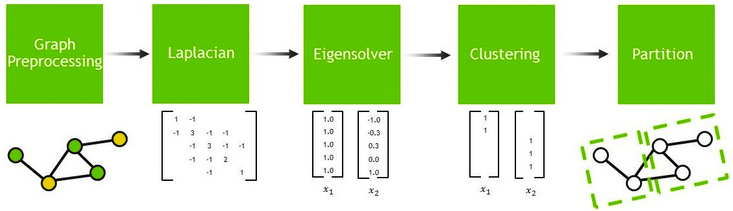

The Laplacian of a graph has non-negative eigenvalues. The number of zero eigenvalues always coincides with the number of connected components. An amazing property of the Laplacian is that its eigenvectors, corresponding to positive eigenvalues in increasing order, describe the graph's cuts - its divisions in such a way that there are as few edges as possible between the divided halves.

Thus, the eigenvector corresponding to the smallest positive eigenvalue will describe the clustering of the graph into two subgraphs. All indices corresponding to positive elements in the vector define the nodes that should belong to the first cluster, while negative elements correspond to nodes that should belong to the second cluster.

This property of the Laplacian graph is used to carry out unsupervised graph clustering (Spectral Clustering). 

For this purpose:

1. Compute the Laplacian L of matrix A.
2. Calculate *k* eigenvectors corresponding to the smallest eigenvalues.
3. Form a matrix of size N x k, where each row describes a node with *k* features.
4. Cluster the nodes described by this matrix (for example, using K-Means).

Thus, the spectral approach is excellent for finding components in a graph whose vertices are connected to each other and have similar properties.

##### Spectral paradigm implementations

 - GCN - based on spectral paradigm and uses only hidden states of nodes **h** and adjacency matrix A. GCN is one step of the iterative process of finding the eigenvalues of the graph Laplacian: we take the hidden states of the nodes and multiply them by the normalized adjacency matrix – the matrix A, multiplied on the left and on the right by the matrix square root of the matrix D. This step is applied to all channels of the hidden node state. After this step, the updated hidden states are further multiplied by a trainable matrix θ:

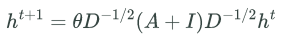

h<sup>j</sup> - is a matrix of size (number of nodes) x (length of the state vector), that is, the convolution is applied separately to each "channel" of representations. If we want to work with multiple channels, instead of h<sup>t</sup> we have to use a matrix H<sup>t</sup> of size (number of vertices) x (number of channels), and we also add nonlinearity f. The formula is then rewritten as follows:

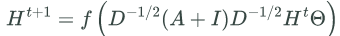

#### Graph representation 

Besides node representation it's also good to represent the whole graph as a vector. How can we do this, if we have node representation?

- Graph Pooling - just sum all the node representations 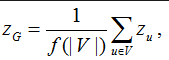, where *f* - some function, if it's identity function - this aggregation turns into averaging. In Readout layers this aggregation is concatenated with element-wise maximum of node representations 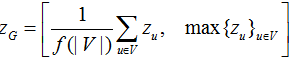

- SortPool - sort nodes (e.g. by the last element in the representation vector), concatenate first k nodes and send them to RNN

- Self-Attention Graph Pooling (SAGPool) - iteratively rate the nodes and only the top-rated nodes are left after each iteration. The process continues until only one node is left or until Readout layer is reached. As the name suggests, SAGPool uses an attention mechanism.

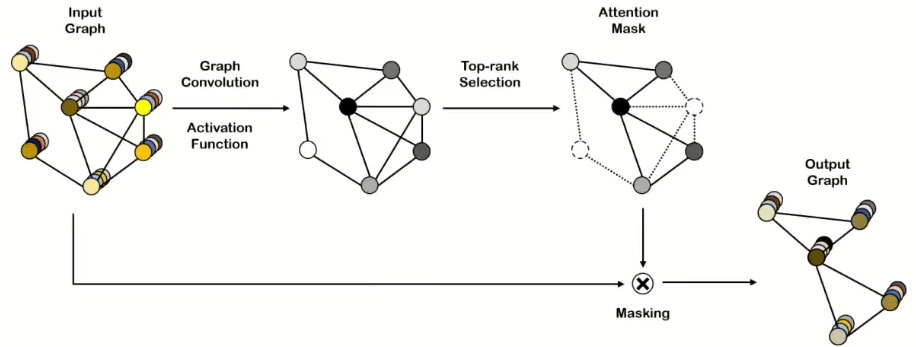

- DiffPool - clusterize graph nodes on every iteration and aggregate nodes inside every cluster

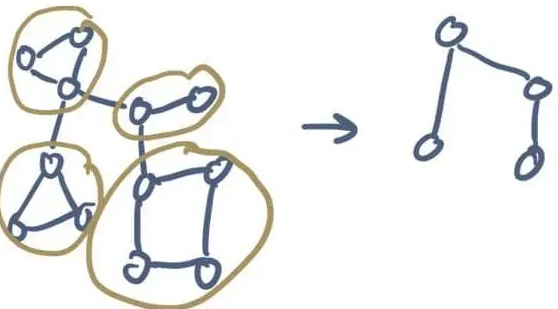

- MinCutPool - similar to DiffPool but uses Spectral Clusterization